# 🌍 Análisis del Cambio Climático y Eventos Extremos

## 1. Introducción
Breve introducción al problema del cambio climático y por qué es relevante analizarlo con datos.

## 2. Objetivos
- Consultar datos públicos de BigQuery sobre calidad del aire (OpenAQ).
- Analizar cambios en los últimos 3 años.
- Visualizar y comparar tendencias de contaminación.
- Obtener conclusiones útiles a partir del análisis.

## 3. Exploración de Datos
- Consulta a la base de datos pública `bigquery-public-data.openaq.global_air_quality`.
- Filtro temporal: últimos 3 años.
- Parámetros seleccionados: `pm25`, `pm10`, `o3`, etc.

## 4. Limpieza y Transformación
- Conversión de columnas de fechas.
- Filtrado por regiones o países (opcional).
- Revisión de valores nulos y formatos.

## 5. Visualización de Datos
- Gráfico 1: Mapa de calor geográfico (con `Folium` o `GeoPandas`).
- Gráfico 2: Comparación de PM10 vs PM2.5 en regiones seleccionadas.
- Gráfico 3: Tendencia temporal de PM2.5 global.
- Gráfico 4: Boxplot por país o región.
- Gráfico 5: Distribución por estación del año o mes.

## 6. Análisis e Interpretación
- ¿Qué tendencias se observan en los datos?
- ¿Ha mejorado o empeorado la calidad del aire?
- ¿Qué regiones presentan mayor contaminación?

## 7. Guardado y exportación
- Exportar resultados como `.csv` si es necesario.
- Guardar figuras con `plt.savefig(...)` si se incluyen en el repositorio.

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account
import folium
from folium.plugins import HeatMap
from datetime import datetime, timedelta
from branca.element import Template, MacroElement
from branca.colormap import linear
from IPython.display import HTML


In [118]:
credenciales = service_account.Credentials.from_service_account_file(
    "/Users/otymar/Downloads/mineria-de-datos-454019-cc0d5d8c0fe5.json"
)

# Crear cliente de BigQuery
cliente = bigquery.Client(credentials=credenciales, project=credenciales.project_id)


# Gráfico 1: Mapa de calor geográfico PM2.5

In [116]:
fecha_inicio = (datetime.utcnow() - timedelta(days=1095)).strftime("%Y-%m-%d")  # 3 años


consulta = """
SELECT city, location, timestamp, value, unit, pollutant, latitude, longitude
FROM `bigquery-public-data.openaq.global_air_quality`
WHERE pollutant IN ('pm25')
  AND value IS NOT NULL
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
LIMIT 100000
"""


resultado = cliente.query(consulta).result().to_dataframe()
print(resultado.shape)
print(resultado[["timestamp", "value", "latitude", "longitude"]].head())


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/1299993907.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  fecha_inicio = (datetime.utcnow() - timedelta(days=1095)).strftime("%Y-%m-%d")  # 3 años


(100000, 8)
                  timestamp      value  latitude  longitude
0 2022-05-03 11:00:00+00:00   8.880000       1.0  53.352778
1 2020-10-20 13:00:00+00:00  18.164000       1.0  42.659656
2 2022-04-30 06:00:00+00:00   3.083333       1.0  56.954847
3 2022-05-09 10:00:00+00:00  55.580000       1.0 -12.028694
4 2022-05-12 02:00:00+00:00  13.500000       1.0  45.698028


In [88]:
resultado = resultado.dropna(subset=["latitude", "longitude", "value"])
resultado = resultado[
    (resultado["latitude"].between(-90, 90)) &
    (resultado["longitude"].between(-180, 180))
]
resultado["value"] = pd.to_numeric(resultado["value"], errors="coerce")


In [180]:
# Coordenadas promedio como centro
center_lat = resultado["latitude"].mean()
center_lon = resultado["longitude"].mean()

# Crear mapa centrado
m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

# Lista de datos para heatmap
heat_data = [[row["latitude"], row["longitude"], row["value"]] for index, row in resultado.iterrows()]

# Agregar capa HeatMap
HeatMap(heat_data, radius=30, blur=10, max_zoom=5).add_to(m)

# Agregar leyenda personalizada
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 40px;
    left: 40px;
    z-index:9999;
    background-color: rgba(255, 255, 255, 0.9);
    padding: 15px 20px;
    border: 1px solid #aaa;
    border-radius: 8px;
    font-size: 14px;
    box-shadow: 0 2px 8px rgba(0,0,0,0.3);
    line-height: 1.5;
">
    <div style="font-weight: bold; margin-bottom: 5px;">Contaminación<br>(PM25)</div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background: #0000ff; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Muy baja
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background: #00ffff; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Baja
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background: #ffff00; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Media
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background: #ff9900; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Alta
    </div>
    <div style="display: flex; align-items: center;">
        <div style="background: #ff0000; width: 18px; height: 18px; margin-right: 8px; opacity:0.7; border-radius: 3px;"></div>
        Muy Alta
    </div>
</div>
{% endmacro %}
"""


legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# Guardar mapa
m.save("mapa_pm25_mundial_ultimo_anio.html")
m

# Gráfico 2: Comparación de PM2.5 y PM10 en 4 lugares

In [90]:
client = bigquery.Client()

# Consulta exploratoria
query = """
SELECT *
FROM `bigquery-public-data.openaq.global_air_quality`
LIMIT 5
"""

df_preview = client.query(query).to_dataframe()
print(df_preview.columns)
print(df_preview.head())


Index(['location', 'city', 'country', 'pollutant', 'value', 'timestamp',
       'unit', 'source_name', 'latitude', 'longitude',
       'averaged_over_in_hours', 'location_geom'],
      dtype='object')
                  location      city country pollutant    value  \
0   Borówiec, ul. Drapałka  Borówiec      PL        bc  0.85217   
1    Kraków, ul. Bulwarowa    Kraków      PL        bc  0.91284   
2          Płock, ul. Reja     Płock      PL        bc  1.41000   
3  Elbląg, ul. Bażyńskiego    Elbląg      PL        bc  0.33607   
4  Piastów, ul. Pułaskiego   Piastów      PL        bc  0.51000   

                  timestamp   unit source_name  latitude  longitude  \
0 2022-04-28 07:00:00+00:00  µg/m³        GIOS       1.0  52.276794   
1 2022-04-27 23:00:00+00:00  µg/m³        GIOS       1.0  50.069308   
2 2022-03-30 04:00:00+00:00  µg/m³        GIOS       1.0  52.550938   
3 2022-05-03 13:00:00+00:00  µg/m³        GIOS       1.0  54.167847   
4 2022-05-11 05:00:00+00:00  µg/m³       

In [91]:
# Cliente
client = bigquery.Client()

# Fechas
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=3*365)

# Consulta funcional
query = f"""
SELECT
  country,
  city,
  location,
  pollutant AS parameter,
  value,
  unit,
  timestamp
FROM
  `bigquery-public-data.openaq.global_air_quality`
WHERE
  pollutant IN ('pm25', 'pm10')
  AND country IN ('CL', 'FR', 'IN', 'US')
  AND timestamp BETWEEN TIMESTAMP('{start_date.strftime('%Y-%m-%d')}') AND TIMESTAMP('{end_date.strftime('%Y-%m-%d')}')
"""

df = client.query(query).to_dataframe()
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["year_month"] = df["timestamp"].dt.to_period("M").astype(str)

/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/3857758356.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow()
/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/3857758356.py:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["timestamp"].dt.to_period("M").astype(str)


In [92]:
# Agrupamos el valor promedio mensual por país y contaminante
grouped = (
    df.groupby(["country", "parameter", "year_month"])["value"]
    .mean()
    .reset_index()
    .pivot(index="year_month", columns=["country", "parameter"], values="value")
)

# Aseguramos que el índice esté ordenado
grouped = grouped.sort_index()
grouped.head()


country            CL                    FR                     IN  \
parameter        pm10       pm25       pm10       pm25        pm10   
year_month                                                           
2022-03     59.668050  25.174905  28.119922  17.070803  195.192696   
2022-04     56.141982  35.292523  16.783678   9.548521  176.663959   
2022-05     63.448751  43.569982  17.938803   8.681407  142.189847   

country                        US            
parameter         pm25       pm10      pm25  
year_month                                   
2022-03     102.253812  17.993750  6.385202  
2022-04      74.545004  28.161684  6.782856  
2022-05      59.710238  26.088782  6.082321

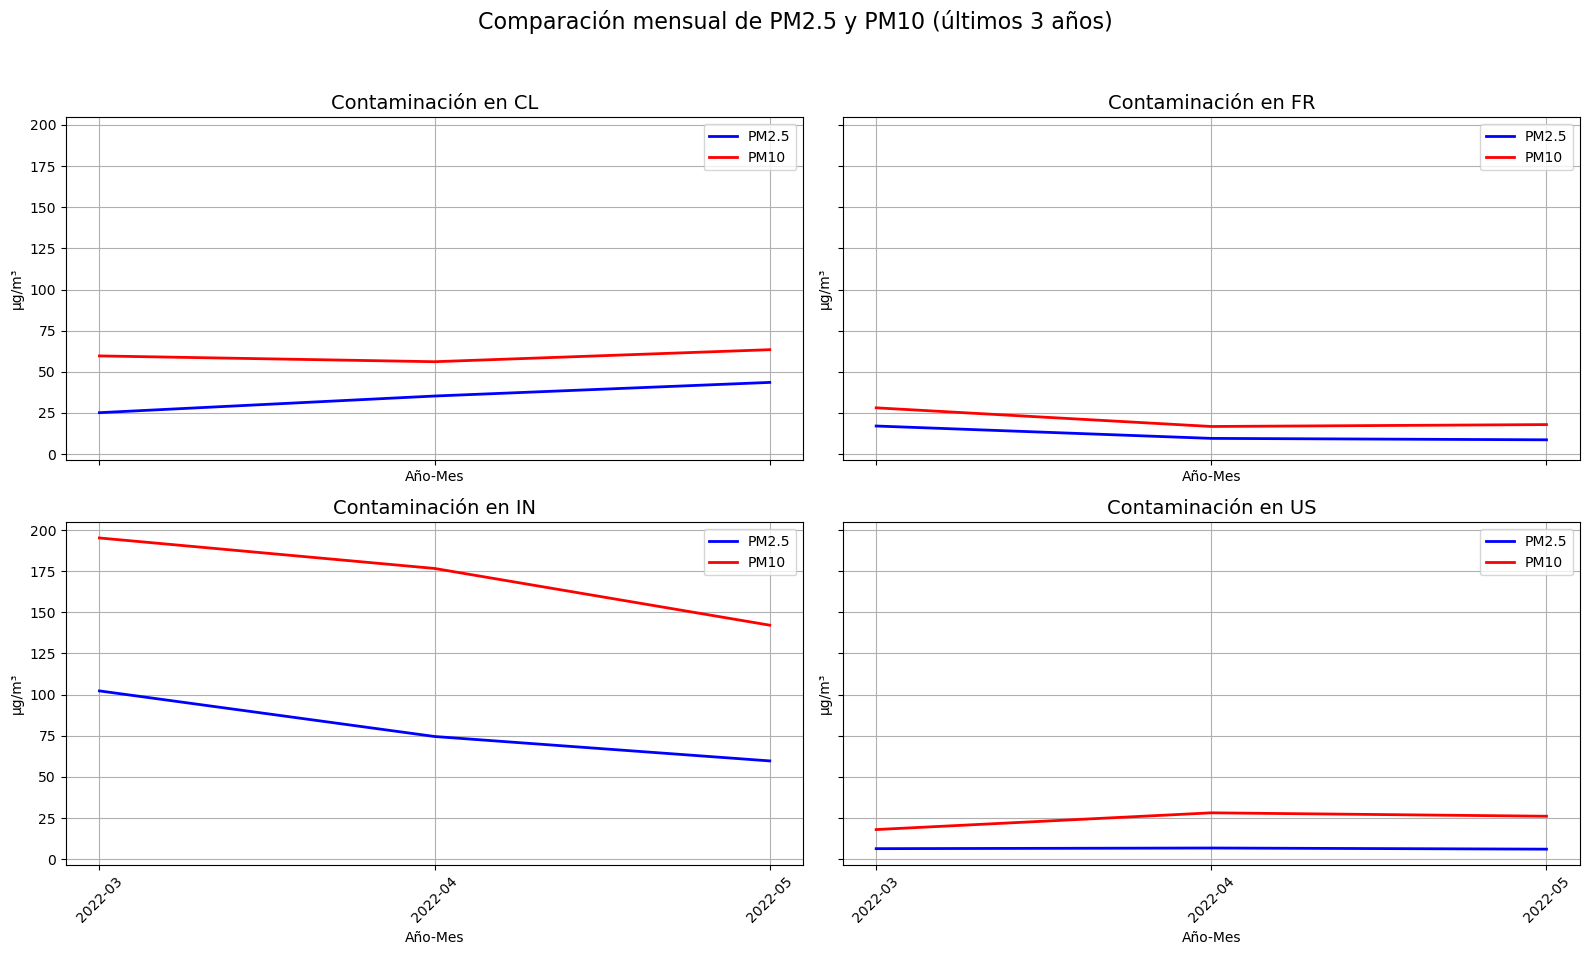

In [93]:

# Países a mostrar
paises = ['CL', 'FR', 'IN', 'US']
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, pais in enumerate(paises):
    ax = axes[i]
    ax.plot(grouped.index, grouped[(pais, 'pm25')], label="PM2.5", color="blue", linewidth=2)
    ax.plot(grouped.index, grouped[(pais, 'pm10')], label="PM10", color="red", linewidth=2)
    ax.set_title(f"Contaminación en {pais}", fontsize=14)
    ax.set_xlabel("Año-Mes")
    ax.set_ylabel("µg/m³")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    ax.legend()

fig.suptitle("Comparación mensual de PM2.5 y PM10 (últimos 3 años)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Gráfico 3: Tendencia temporal de PM2.5

In [120]:
query = """
SELECT 
  country,
  city,
  location,
  pollutant,
  value,
  unit,
  timestamp
FROM 
  `bigquery-public-data.openaq.global_air_quality`
WHERE 
  pollutant = 'pm25'
  AND timestamp BETWEEN TIMESTAMP('2007-01-01') AND TIMESTAMP('2022-05-31')
"""


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/3450173645.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pm25_global["year_month"] = df_pm25_global["timestamp"].dt.to_period("M").astype(str)


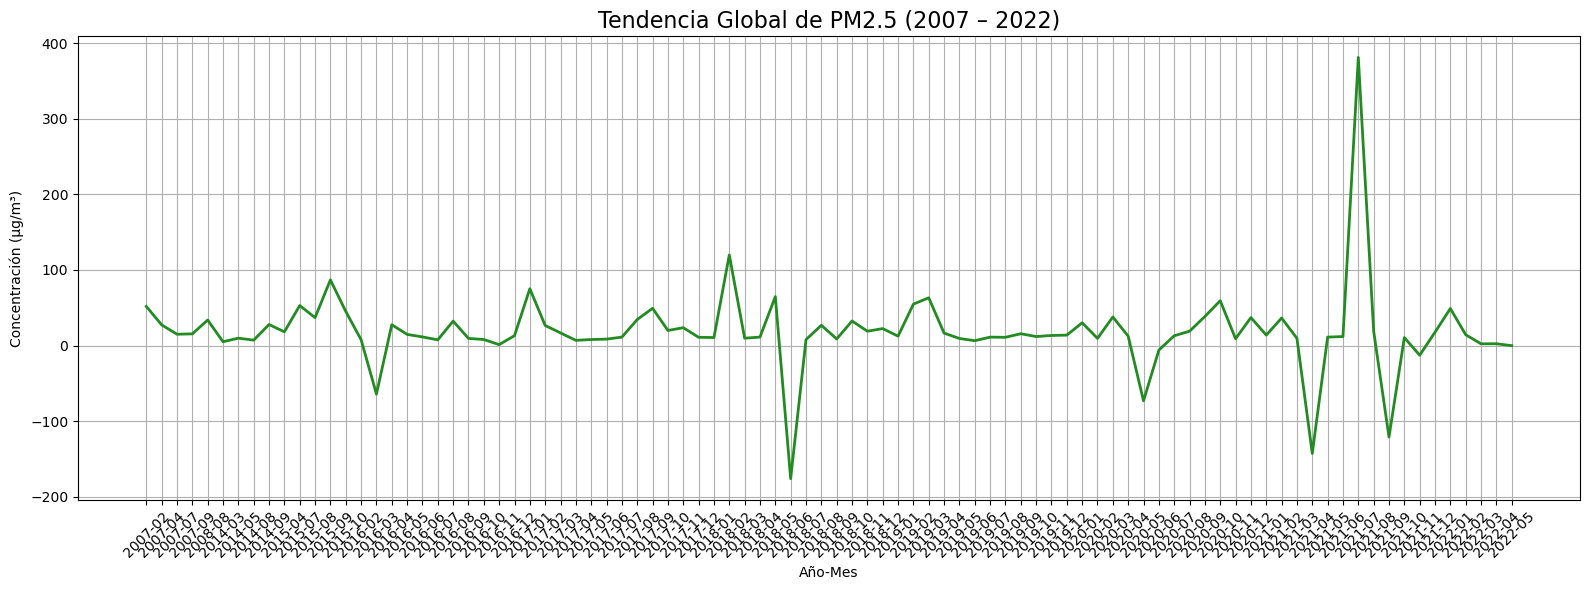

In [179]:
# Asegúrate de haber actualizado la consulta en tu código con el rango 2007–2022
df_pm25_global = client.query(query).to_dataframe()
df_pm25_global["timestamp"] = pd.to_datetime(df_pm25_global["timestamp"])
df_pm25_global["year_month"] = df_pm25_global["timestamp"].dt.to_period("M").astype(str)
df_pm25_global_grouped = (
    df_pm25_global
    .groupby("year_month")["value"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(16, 6))
plt.plot(df_pm25_global_grouped["year_month"], df_pm25_global_grouped["value"], color='forestgreen', linewidth=2)
plt.title("Tendencia Global de PM2.5 (2007 – 2022)", fontsize=16)
plt.xlabel("Año-Mes")
plt.ylabel("Concentración (µg/m³)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Gráfico 4: Boxplot por país 

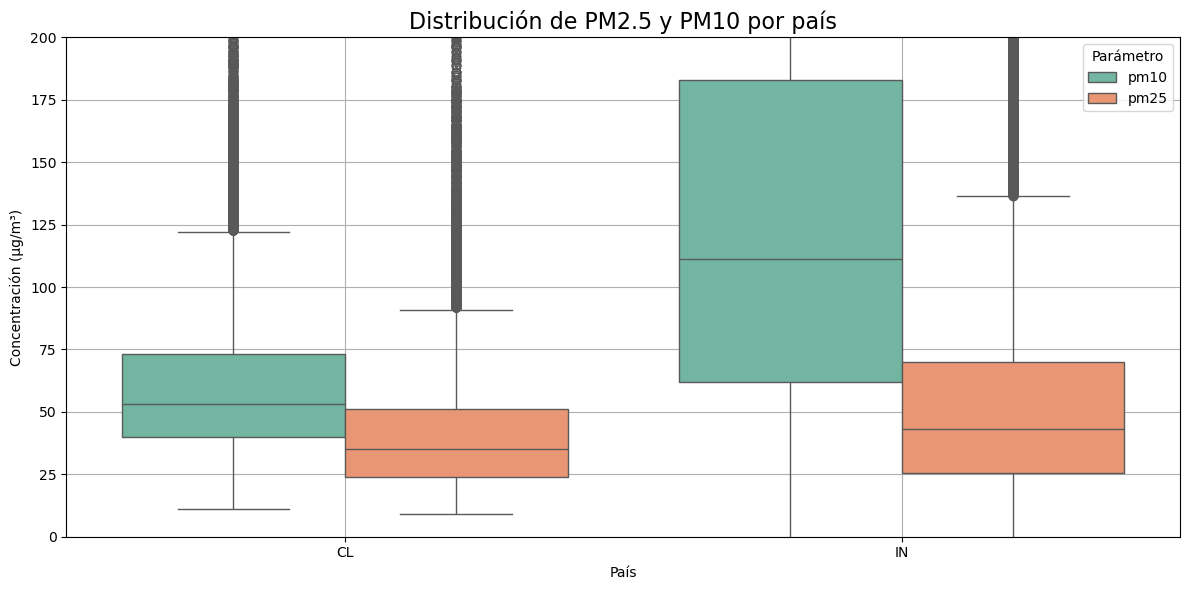

In [129]:
paises_box = ['CL', 'IN', 'NG', 'AU']

# Filtrar PM2.5 y PM10 
df_box = df[df["country"].isin(paises_box) & df["parameter"].isin(["pm25", "pm10"])].copy()

# Crear boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_box,
    x="country",
    y="value",
    hue="parameter",
    palette="Set2"
)

plt.title("Distribución de PM2.5 y PM10 por país", fontsize=16)
plt.xlabel("País")
plt.ylabel("Concentración (µg/m³)")
plt.ylim(0, 200)  
plt.grid(True)
plt.legend(title="Parámetro")
plt.tight_layout()
plt.show()


In [130]:
print(df_box["country"].value_counts())


country
IN    262590
CL     80689
Name: count, dtype: int64


In [131]:
print(df_box.groupby(["country", "parameter"]).size())


country  parameter
CL       pm10          38723
         pm25          41966
IN       pm10         128829
         pm25         133761
dtype: int64


In [136]:
top_paises = (
    df[df["parameter"].isin(["pm25", "pm10"])]
    .groupby("country")
    .size()
    .sort_values(ascending=False)
    .head(5)  
    .index.tolist()
)
df_box = df[df["country"].isin(top_paises) & df["parameter"].isin(["pm25", "pm10"])]
df_box

country        city                     location parameter  value  \
0            CL  Talcahuano               Nueva Libertad      pm10   88.0   
1            CL     Coronel                  Lota urbana      pm10   79.0   
2            CL   Andacollo  Urmeneta - Plaza Centenario      pm10   51.0   
3            CL   Coyhaique                    Coyhaique      pm10   87.0   
4            CL   Quilicura                    Quilicura      pm10   89.0   
...         ...         ...                          ...       ...    ...   
1031020      US  CHARLESTON         North Charleston F.S      pm25    3.2   
1031021      US  CHARLESTON               SPA-Irving St.      pm25    4.8   
1031022      US       CEDAR                     ELDOSPGS      pm25    2.6   
1031023      US      DAKOTA         Lakeville - Near Roa      pm25   -1.0   
1031024      US      Dayton                 Preble NCore      pm25    4.5   

          unit                 timestamp year_month  
0        µg/m³ 2022-05-14 10:00:00+00:00    2022-05  
1        µg/m³ 2022-05-15 12:00:00+00:00    2022-05  
2        µg/m³ 2022-05-15 20:00:00+00:00    2022-05  
3        µg/m³ 2022-05-14 16:00:00+00:00    2022-05  
4        µg/m³ 2022-05-03 05:00:00+00:00    2022-05  
...        ...                       ...        ...  
1031020  µg/m³ 2022-05-15 05:00:00+00:00    2022-05  
1031021  µg/m³ 2022-05-10 21:00:00+00:00    2022-05  
1031022  µg/m³ 2022-05-19 19:00:00+00:00    2022-05  
1031023  µg/m³ 2022-05-02 07:00:00+00:00    2022-05  
1031024  µg/m³ 2022-05-08 18:00:00+00:00    2022-05  

[1031025 rows x 8 columns]

### Por falta de datos en los paises seleccionados, seleccionaremos 4 regiones con más datos de Chile

In [137]:
# Filtramos solo Chile
df_chile = df[df["country"] == "CL"]

# Obtenemos las 4 ciudades con más registros
top_ciudades = (
    df_chile["city"]
    .value_counts()
    .head(4)
    .index.tolist()
)

print("Top 4 ciudades con más datos:", top_ciudades)


Top 4 ciudades con más datos: ['Coronel', 'Calama', 'Puchuncaví', 'Quintero']


In [138]:
# Filtramos para esas 4 ciudades y los parámetros PM2.5 y PM10
df_box_ciudades = df_chile[
    df_chile["city"].isin(top_ciudades) &
    df_chile["parameter"].isin(["pm25", "pm10"]) &
    (df_chile["value"] < 500)  # Limpiamos outliers extremos
]


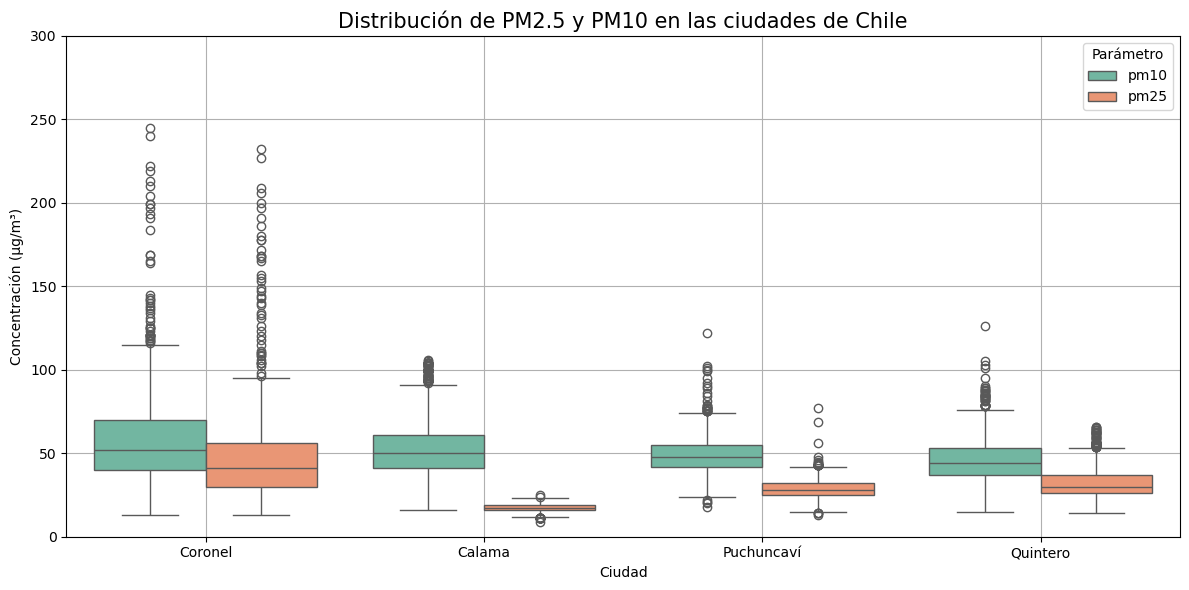

In [177]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_box_ciudades,
    x="city",
    y="value",
    hue="parameter",
    palette="Set2"
)

plt.title("Distribución de PM2.5 y PM10 en las ciudades de Chile", fontsize=15)
plt.xlabel("Ciudad")
plt.ylabel("Concentración (µg/m³)")
plt.grid(True)
plt.ylim(0, 300)
plt.legend(title="Parámetro")
plt.tight_layout()
plt.show()

# Gráfico 5: Distribución de contaminantes por mes y año en Chile

In [ ]:
client = bigquery.Client()

query_chile = """
SELECT
  country,
  city,
  location,
  pollutant,
  value,
  unit,
  timestamp,
  latitude,
  longitude
FROM
  `bigquery-public-data.openaq.global_air_quality`
WHERE
  country = 'CL'
  AND pollutant IN ('pm25', 'pm10')
  AND timestamp BETWEEN TIMESTAMP('2020-01-01') AND TIMESTAMP('2023-12-31')
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
  AND value IS NOT NULL
"""

df_chile = client.query(query_chile).to_dataframe()

# Procesamiento temporal
df_chile["timestamp"] = pd.to_datetime(df_chile["timestamp"])
df_chile["year"] = df_chile["timestamp"].dt.year
df_chile["month"] = df_chile["timestamp"].dt.month
df_chile["year_month"] = df_chile["timestamp"].dt.to_period("M").astype(str)

df_chile.head()


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/3419722956.py:34: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_chile["year_month"] = df_chile["timestamp"].dt.to_period("M").astype(str)


country       city     location pollutant  value   unit  \
0      CL  Tocopilla  Gobernación      pm10   42.0  µg/m³   
1      CL  Tocopilla  Gobernación      pm10   54.0  µg/m³   
2      CL  Tocopilla  Gobernación      pm10   42.0  µg/m³   
3      CL    Coronel  Coronel Sur      pm10  106.0  µg/m³   
4      CL    Coronel  Coronel Sur      pm10   37.0  µg/m³   

                  timestamp  latitude  longitude  year  month year_month  
0 2022-05-06 02:00:00+00:00       1.0 -22.093082  2022      5    2022-05  
1 2022-05-23 19:00:00+00:00       1.0 -22.093082  2022      5    2022-05  
2 2022-05-15 23:00:00+00:00       1.0 -22.093082  2022      5    2022-05  
3 2022-05-12 04:00:00+00:00       1.0 -37.031702  2022      5    2022-05  
4 2022-04-09 01:00:00+00:00       1.0 -37.031702  2022      4    2022-04

In [ ]:

# Centrar en Chile
m_chile = folium.Map(location=[-35.6751, -71.5430], zoom_start=5)

# Filtrar por PM2.5 y PM10 con valores razonables
df_chile_heat = df_chile[
    df_chile["value"] <= 500  # puedes ajustar este umbral
]

# Crear lista de puntos: [lat, lon, intensidad]
heat_data = [
    [row["latitude"], row["longitude"], row["value"]]
    for _, row in df_chile_heat.iterrows()
]

# Añadir capa de mapa de calor
HeatMap(heat_data, radius=10, blur=15, max_zoom=7).add_to(m_chile)

# Guardar como archivo HTML
m_chile.save("mapa_calor_chile.html")
m_chile

In [169]:
print(df_chile[["latitude", "longitude"]].isna().sum())
print(df_chile.shape[0], "total rows")
print(df_chile.dropna(subset=["latitude", "longitude"]).shape[0], "rows with coordinates")


latitude     0
longitude    0
dtype: int64
80703 total rows
80703 rows with coordinates


### chile no se ve xD nos vamos a Brasil 🇧🇷 🇧🇷 🇧🇷

In [ ]:
# Crear cliente
client = bigquery.Client()

# Consulta para obtener datos de PM2.5 y PM10 en Brasil
query_brasil = """
SELECT
  country,
  city,
  location,
  pollutant,
  value,
  unit,
  latitude,
  longitude,
  timestamp
FROM
  `bigquery-public-data.openaq.global_air_quality`
WHERE
  country = 'BR'
  AND pollutant IN ('pm25', 'pm10')
  AND value IS NOT NULL
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
"""

# Ejecutar consulta y cargar en DataFrame
df_brasil = client.query(query_brasil).to_dataframe()

# Procesar timestamp
df_brasil["timestamp"] = pd.to_datetime(df_brasil["timestamp"])
df_brasil["year"] = df_brasil["timestamp"].dt.year
df_brasil["month"] = df_brasil["timestamp"].dt.month
df_brasil["year_month"] = df_brasil["timestamp"].dt.to_period("M").astype(str)
df_brasil.head()


/var/folders/l0/y6_kn2kj5ysb_90cx_wmwcvm0000gn/T/ipykernel_22785/1640477615.py:35: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_brasil["year_month"] = df_brasil["timestamp"].dt.to_period("M").astype(str)


country                   city                location pollutant  value  \
0      BR  São Bernardo do Campo    S.Bernardo-Paulicéia      pm10   43.0   
1      BR                  Bauru                   Bauru      pm10   26.0   
2      BR            Santo André  S.André-Paço Municipal      pm10   46.0   
3      BR        Santa Gertrudes         Santa Gertrudes      pm10   19.0   
4      BR            Santo André         S.André-Capuava      pm10   36.0   

    unit   latitude  longitude                 timestamp  year  month  \
0  µg/m³ -23.671354 -46.584667 2017-10-27 18:00:00+00:00  2017     10   
1  µg/m³ -22.326609 -49.092760 2017-10-27 18:00:00+00:00  2017     10   
2  µg/m³ -23.656994 -46.530920 2017-10-27 18:00:00+00:00  2017     10   
3  µg/m³ -22.459955 -47.536297 2017-09-30 13:00:00+00:00  2017      9   
4  µg/m³ -23.639803 -46.491640 2017-10-27 18:00:00+00:00  2017     10   

  year_month  
0    2017-10  
1    2017-10  
2    2017-10  
3    2017-09  
4    2017-10

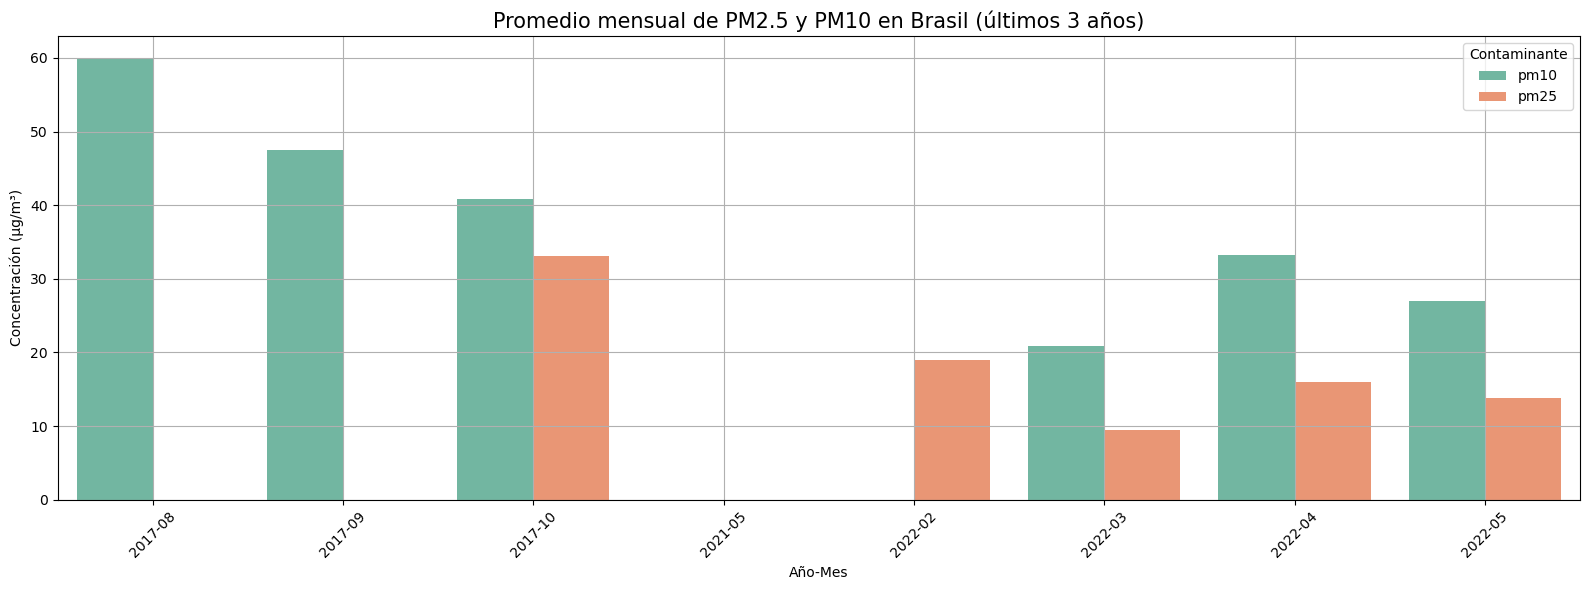

In [176]:

# Asegurarse que 'year' esté como número y filtrar últimos 3 años disponibles
años_disponibles = sorted(df_brasil["year"].unique())[-3:]  # últimos 3 años disponibles
df_ultimos = df_brasil[df_brasil["year"].isin(años_disponibles)]

# Agrupar por año, mes y contaminante
df_mensual = (
    df_ultimos.groupby(["year", "month", "pollutant"])["value"]
    .mean()
    .reset_index()
)

# Convertir mes a nombre para mejor visualización
df_mensual["month"] = df_mensual["month"].apply(lambda x: f"{x:02}")
df_mensual["Mes"] = df_mensual["month"].map({
    "01": "Ene", "02": "Feb", "03": "Mar", "04": "Abr",
    "05": "May", "06": "Jun", "07": "Jul", "08": "Ago",
    "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dic"
})

# Crear columna combinada para el eje x
df_mensual["AñoMes"] = df_mensual["year"].astype(str) + "-" + df_mensual["month"]

# Ordenar correctamente
df_mensual = df_mensual.sort_values(by="AñoMes")

# Plot
plt.figure(figsize=(16, 6))
sns.barplot(
    data=df_mensual,
    x="AñoMes",
    y="value",
    hue="pollutant",
    palette="Set2"
)
plt.title("Promedio mensual de PM2.5 y PM10 en Brasil (últimos 3 años)", fontsize=15)
plt.xlabel("Año-Mes")
plt.ylabel("Concentración (µg/m³)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Contaminante")
plt.tight_layout()
plt.show()
